# 문제01 [g_crypto_currency_regression_train_lstm]

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

In [3]:
# Jupyter Notebook 환경에서도 동작하는 방식으로 BASE_PATH 설정
BASE_PATH = str(Path().resolve().parent.parent)

# 시스템 경로 추가
import sys
sys.path.append(BASE_PATH)

In [4]:
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(os.getcwd()))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

In [5]:
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [6]:
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset

In [7]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

  # X_train.shape: [3212, 10, 5]
  # X_validation.shape: [100, 10, 5]
  # X_test.shape: [10, 10, 5]
  # y_train.shape: [3212]
  # y_validation.shape: [100]
  # y_test.shape: [10]

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader

In [8]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model

In [10]:
if __name__ == "__main__":
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        "wandb": True,  # WandB 사용 여부
        "batch_size": 2048,  # 배치 크기
        "epochs": 10000,  # 학습 에포크 수
        "learning_rate": 1e-4,  # 학습률
        "weight_decay": 0.0,  # 가중치 감소
        "validation_intervals": 30,  # 검증 간격
        "early_stop_patience": 30,  # 조기 종료 patience
        "early_stop_delta": 0.000001,  # 조기 종료 delta
    }

    project_name = "lstm_regression_btc_krw"
    wandb.init(
        mode="online" if config["wandb"] else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    print("Configuration:", config)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    regression_trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()

    wandb.finish()


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/work/.netrc
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Configuration: {'wandb': True, 'batch_size': 2048, 'epochs': 10000, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'validation_intervals': 30, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
Training on device cuda:0.
[Epoch   1] T_loss: 10.28757, V_loss: 79.46783, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.027
[Epoch  30] T_loss: 5.79449, V_loss: 41.98923, V_loss decreased (79.46783 --> 41.98923). Saving model... | T_time: 00:00:01, T_speed: 0.206
[Epoch  60] T_loss: 0.60678, V_loss: 9.85384, V_loss decreased (41.98923 --> 9.85384). Saving model... | T_time: 00:00:02, T_speed: 0.203
[Epoch  90] T_loss: 0.34942, V_loss: 6.96430, V_loss decreased (9.85384 --> 6.96430). Saving model... | T_time: 00:00:03, T_speed: 0.141
[Epoch 120] T_loss: 0.25328, V_loss: 5.18842, V_loss decreased (6.96430 --> 5.18842). Saving model... | T_time: 00:00:04, T_speed: 0.149
[Epoch 150] T_loss: 0.18526, V_loss: 4.02228, V_loss decreased (5.18842 --> 4.02228). Saving model... | T_time: 00:0

[Epoch 1770] T_loss: 0.01609, V_loss: 0.59722, V_loss decreased (0.60490 --> 0.59722). Saving model... | T_time: 00:01:10, T_speed: 103.910
[Epoch 1800] T_loss: 0.01580, V_loss: 0.58852, V_loss decreased (0.59722 --> 0.58852). Saving model... | T_time: 00:01:11, T_speed: 6.304
[Epoch 1830] T_loss: 0.01566, V_loss: 0.58368, V_loss decreased (0.58852 --> 0.58368). Saving model... | T_time: 00:01:12, T_speed: 4.230
[Epoch 1860] T_loss: 0.01547, V_loss: 0.57432, V_loss decreased (0.58368 --> 0.57432). Saving model... | T_time: 00:01:13, T_speed: 3.069
[Epoch 1890] T_loss: 0.01511, V_loss: 0.56850, V_loss decreased (0.57432 --> 0.56850). Saving model... | T_time: 00:01:14, T_speed: 2.489
[Epoch 1920] T_loss: 0.01531, V_loss: 0.56124, V_loss decreased (0.56850 --> 0.56124). Saving model... | T_time: 00:01:15, T_speed: 2.128
[Epoch 1950] T_loss: 0.01508, V_loss: 0.55809, V_loss decreased (0.56124 --> 0.55809). Saving model... | T_time: 00:01:17, T_speed: 9.586
[Epoch 1980] T_loss: 0.01497, V_

[Epoch 3690] T_loss: 0.01026, V_loss: 0.49226, Early stopping counter: 26 out of 30 | T_time: 00:02:25, T_speed: 5.564
[Epoch 3720] T_loss: 0.01015, V_loss: 0.49336, Early stopping counter: 27 out of 30 | T_time: 00:02:26, T_speed: 4.688
[Epoch 3750] T_loss: 0.01023, V_loss: 0.49377, Early stopping counter: 28 out of 30 | T_time: 00:02:27, T_speed: 4.047
[Epoch 3780] T_loss: 0.01002, V_loss: 0.50107, Early stopping counter: 29 out of 30 | T_time: 00:02:29, T_speed: 15.810
[Epoch 3810] T_loss: 0.01021, V_loss: 0.49780, Early stopping counter: 30 out of 30 *** TRAIN EARLY STOPPED! *** | T_time: 00:02:30, T_speed: 9.955
Final training time: 00:02:30


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▃▁▂▁▁▁▁▂▁▂▁▂█▁▁▁▁
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3810
Training loss,0.01021
Training speed (epochs/sec.),9.95519
Validation loss,0.4978


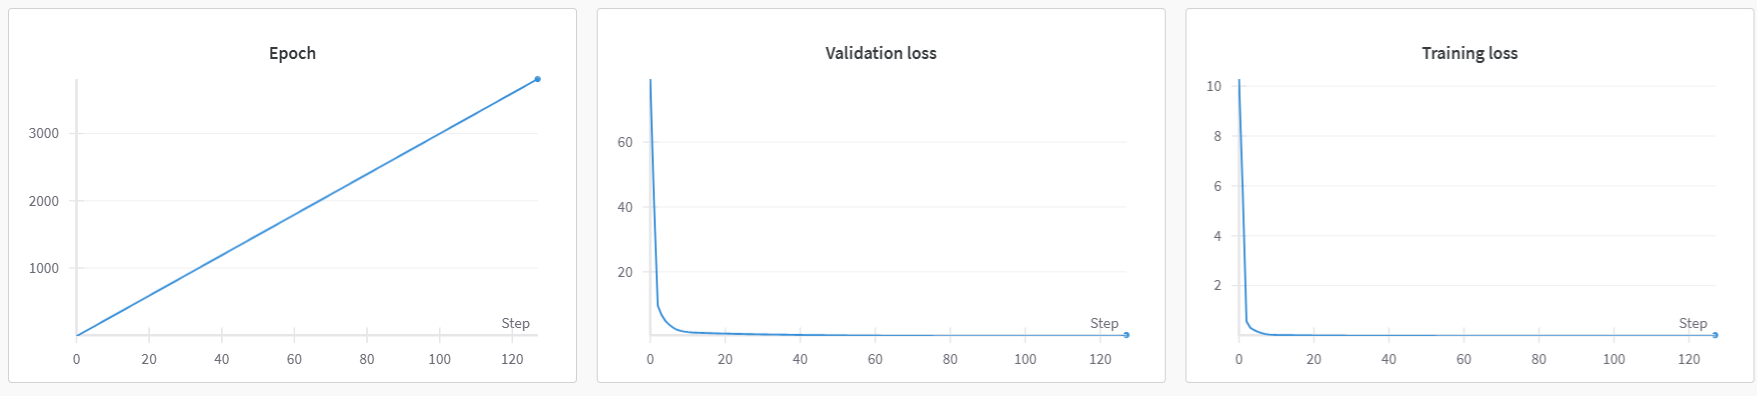

https://wandb.ai/tjsdn052-korea-university-of-technology-and-education5144/lstm_regression_btc_krw/runs/77zmd0j2?nw=nwusertjsdn052

# 문제01 [h_crypto_currency_regression_test_lstm]

In [14]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

In [15]:
BASE_PATH = str(Path().resolve().parent.parent)

# 시스템 경로 추가
import sys
sys.path.append(BASE_PATH)

In [16]:
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(os.getcwd()))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [17]:
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data

In [18]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

In [20]:
def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

Configuration: {'wandb': True, 'batch_size': 2048, 'epochs': 10000, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'validation_intervals': 30, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
MODEL FILE: /home/work/HW4/link_dl/_01_code/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,097.75 <--> 1,319.45 (Loss:        221.70)
 1: 1,113.85 <--> 1,302.60 (Loss:        188.76)
 2: 1,103.05 <--> 1,390.43 (Loss:        287.38)
 3: 1,111.36 <--> 1,284.38 (Loss:        173.02)
 4: 1,107.23 <--> 1,334.58 (Loss:        227.35)
 5: 1,101.33 <--> 1,380.87 (Loss:        279.54)
 6: 1,108.31 <--> 1,331.62 (Loss:        223.31)
 7: 1,107.37 <--> 1,373.29 (Loss:        265.92)
 8: 1,111.86 <--> 1,378.05 (Loss:        266.19)
 9: 1,110.52 <--> 1,360.09 (Loss:        249.58)


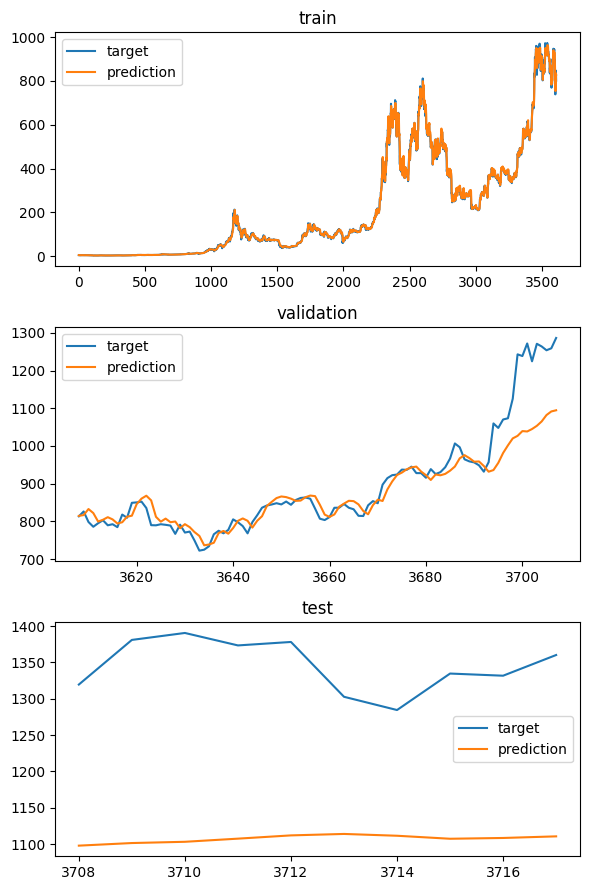

In [23]:
if __name__ == "__main__":
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        "wandb": True,  # WandB 사용 여부 (비활성화)
        "batch_size": 2048,  # 배치 크기
        "epochs": 10000,  # 학습 에포크 수
        "learning_rate": 1e-4,  # 학습률
        "weight_decay": 0.0,  # 가중치 감소
        "validation_intervals": 30,  # 검증 간격
        "early_stop_patience": 30,  # 조기 종료 patience
        "early_stop_delta": 0.000001,  # 조기 종료 delta
    }

    project_name = "lstm_regression_btc_krw"
    wandb.init(
        mode="online",  # WandB 비활성화
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    print("Configuration:", config)

    test_model = get_model()

    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    test(test_model)
    predict_all(test_model)

# 문제01 [i_crypto_currency_classification_train_lstm]

In [3]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

In [4]:
BASE_PATH = str(Path().resolve().parent.parent)

# 시스템 경로 추가
import sys
sys.path.append(BASE_PATH)

In [5]:
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(os.getcwd()))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

In [6]:
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [7]:
from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data

In [8]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model

In [9]:
if __name__ == "__main__":
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        "wandb": True,  # WandB 사용 여부
        "batch_size": 2048,  # 배치 크기
        "epochs": 10000,  # 학습 에포크 수
        "learning_rate": 1e-4,  # 학습률
        "weight_decay": 0.0,  # 가중치 감소
        "validation_intervals": 30,  # 검증 간격
        "early_stop_patience": 30,  # 조기 종료 patience
        "early_stop_delta": 0.000001,  # 조기 종료 delta
    }

    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="online" if config["wandb"] else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    print("Configuration:", config)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tjsdn052 (tjsdn052-korea-university-of-technology-and-education5144). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Configuration: {'wandb': True, 'batch_size': 2048, 'epochs': 10000, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'validation_intervals': 30, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69167, T_accuracy: 52.7993 | V_loss: 0.68922, V_accuracy: 56.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69048, T_accuracy: 53.1874 | V_loss: 0.69854, V_accuracy: 44.0000 | Early stopping counter: 1 out of 30 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69063, T_accuracy: 53.1042 | V_loss: 0.69725, V_accuracy: 44.0000 | Early stopping counter: 2 out of 30 | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69067, T_accuracy: 53.1042 | V_loss: 0.69756, V_accuracy: 44.0000 | Early stopping counter: 3 out of 30 | T_time: 00:00:04, T_speed: 22.500
[Epoch 120] T_loss: 0.69050, T_accuracy: 53.0765 | V_loss: 0.69801, V_accuracy: 44.0000 | Early stopping counter: 4 out of 30 | T_time: 00:0

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇█
Training loss,██████████████████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁
Training speed (epochs/sec.),▁█▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation accuracy (%),▇▁▁▁▁▁▁▁▁▁▁▆▆▇▇▆▇▇█▆█▇▇▆▅▅▆▆█▅▇▆▆▆▅█▇▆▇▆
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇█
Epoch,1290
Training accuracy (%),61.19734
Training loss,0.59744
Training speed (epochs/sec.),21.86441
Validation accuracy (%),54


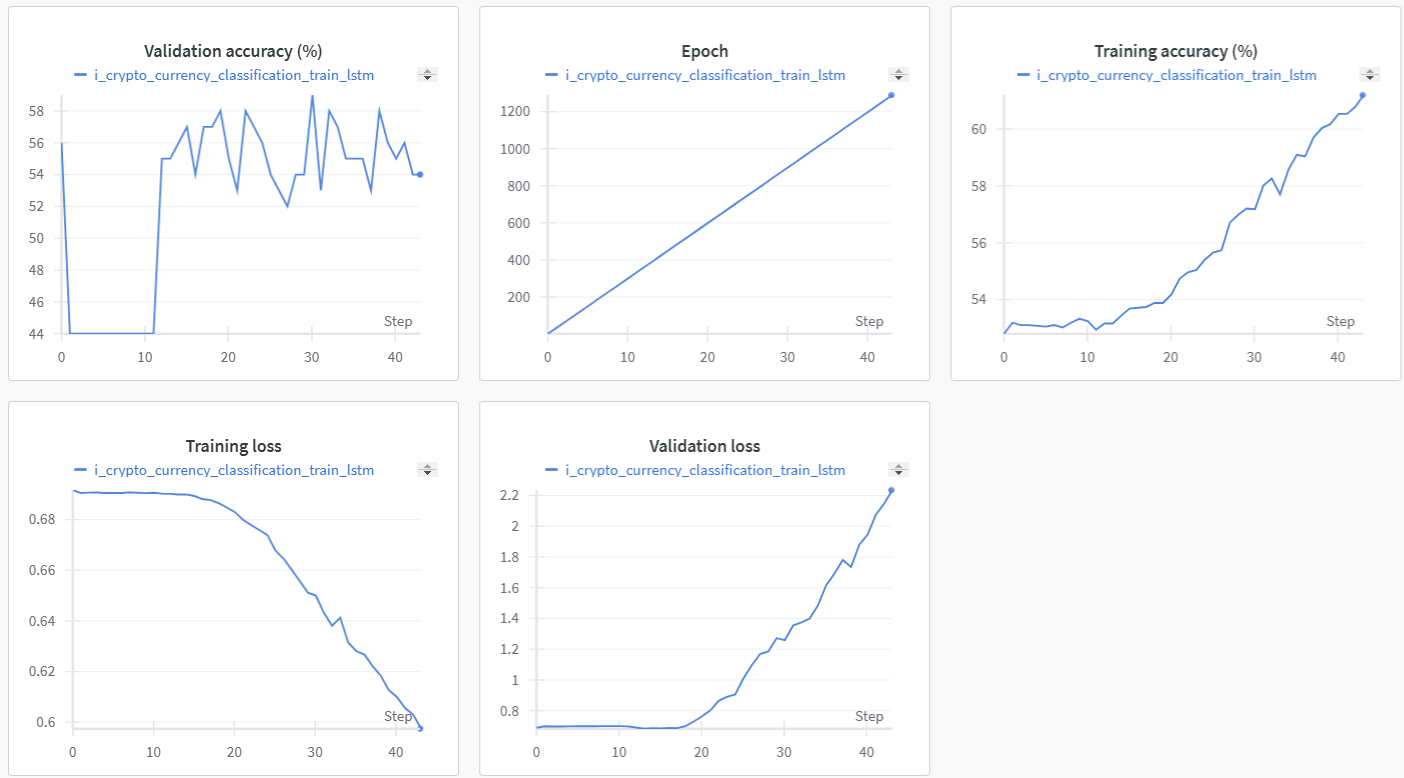

https://wandb.ai/tjsdn052-korea-university-of-technology-and-education5144/lstm_classification_btc_krw/runs/4vvlm3xg?nw=nwusertjsdn052

# 문제01 [j_crypto_currency_classification_test_lstm]

In [2]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

In [3]:
BASE_PATH = str(Path().resolve().parent.parent)

import sys
sys.path.append(BASE_PATH)

In [4]:
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(os.getcwd()))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

In [5]:
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [6]:
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model

In [9]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

In [10]:
if __name__ == "__main__":
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        "wandb": False,  # WandB 비활성화
        "batch_size": 2048,  # 배치 크기
        "epochs": 10000,  # 학습 에포크 수
        "learning_rate": 1e-4,  # 학습률
        "validation_intervals": 30,  # 검증 간격
        "early_stop_patience": 30,  # 조기 종료 patience
        "early_stop_delta": 0.000001,  # 조기 종료 delta
    }

    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="disabled",  # WandB 비활성화
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    print("Configuration:", config)

    test_model = get_model()

    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device("cpu")))

    test(test_model)


Configuration: {'wandb': False, 'batch_size': 2048, 'epochs': 10000, 'learning_rate': 0.0001, 'validation_intervals': 30, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
MODEL FILE: /home/work/HW4/link_dl/_01_code/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 60.000%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   0.00
 3:   0.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   0.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   0.00
 9:   0.00 <-->   0.00


# 문제02 [h_crypto_currency_regression_test_lstm]

In [1]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
from torch import nn, optim
import os
from pathlib import Path

In [2]:
BASE_PATH = str(Path().resolve().parent.parent)

# 시스템 경로 추가
import sys
sys.path.append(BASE_PATH)

In [3]:
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(os.getcwd()))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [4]:
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data

In [5]:
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=1, batch_first=True)
            self.fc1 = nn.Linear(in_features=128, out_features=64)  
            self.fc2 = nn.Linear(in_features=64, out_features= 32)  
            self.fc3 = nn.Linear(in_features=32, out_features=n_output) 



        def forward(self, x):
            x, _ = self.lstm(x)  
            x = x[:, -1, :] 
            x = self.fc1(x) 
            x = self.fc2(x) 
            x = self.fc3(x)
            return x

    return MyModel(n_input=5, n_output=1)



In [6]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

In [7]:
def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tjsdn052 (tjsdn052-korea-university-of-technology-and-education5144). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Configuration: {'wandb': True, 'batch_size': 2048, 'epochs': 10000, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'validation_intervals': 30, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
MODEL FILE: /home/work/HW4/link_dl/_01_code/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,317.31 <--> 1,360.09 (Loss:         42.78)
 1: 1,264.03 <--> 1,334.58 (Loss:         70.55)
 2: 1,351.35 <--> 1,302.60 (Loss:         48.74)
 3: 1,265.02 <--> 1,319.45 (Loss:         54.43)
 4: 1,287.55 <--> 1,284.38 (Loss:          3.17)
 5: 1,324.97 <--> 1,390.43 (Loss:         65.46)
 6: 1,310.62 <--> 1,331.62 (Loss:         20.99)
 7: 1,357.86 <--> 1,373.29 (Loss:         15.43)
 8: 1,363.01 <--> 1,378.05 (Loss:         15.04)
 9: 1,288.40 <--> 1,380.87 (Loss:         92.47)


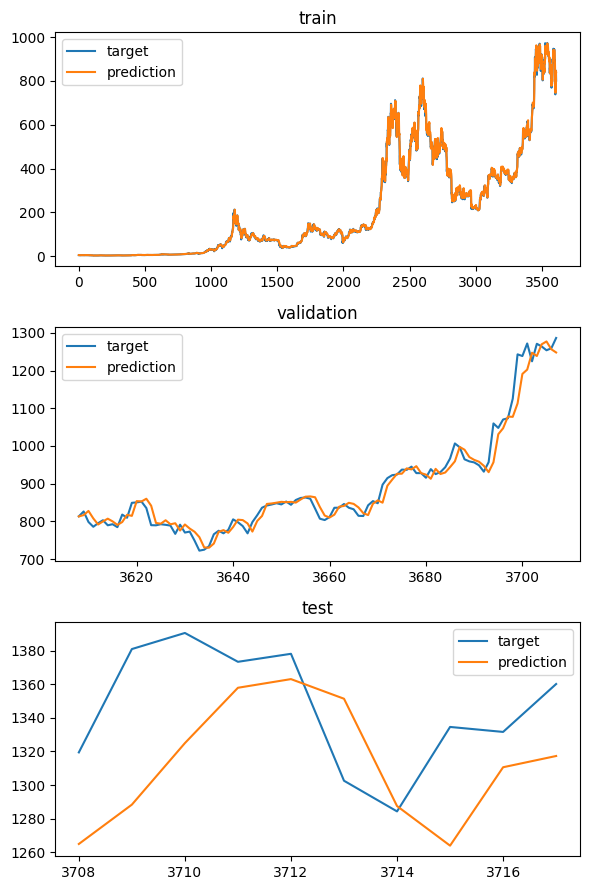

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [8]:
if __name__ == "__main__":
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        "wandb": True,  # WandB 사용 여부 (비활성화)
        "batch_size": 2048,  # 배치 크기
        "epochs": 10000,  # 학습 에포크 수
        "learning_rate": 1e-4,  # 학습률
        "weight_decay": 0.0,  # 가중치 감소
        "validation_intervals": 30,  # 검증 간격
        "early_stop_patience": 30,  # 조기 종료 patience
        "early_stop_delta": 0.000001,  # 조기 종료 delta
    }

    project_name = "lstm_regression_btc_krw"
    wandb.init(
        mode="online",  # WandB 비활성화
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    print("Configuration:", config)

    test_model = get_model()

    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    test(test_model)
    predict_all(test_model)

LSTM Layers: 1 Linear Layer : 3 . dropout과 weight_decay는 사용하지 않았다. dropout, weight_decay을 사용하면 사용하지 않은것보다 V_loss가 높게 나오는 결과를 보였다.


https://wandb.ai/tjsdn052-korea-university-of-technology-and-education5144/lstm_regression_btc_krw?nw=nwusertjsdn052

# 문제02 [j_crypto_currency_classification_test_lstm]

In [30]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb
from torch import nn, optim

In [31]:
BASE_PATH = str(Path().resolve().parent.parent)

import sys
sys.path.append(BASE_PATH)

In [32]:
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(os.getcwd()))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

In [33]:
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [34]:
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._15_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model

In [41]:
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=1, batch_first=True)
            self.fc1 = nn.Linear(in_features=256, out_features=128) 
            self.fc2 = nn.Linear(in_features=128, out_features= n_output) 


        def forward(self, x):
            x, _ = self.lstm(x) 
            x = x[:, -1, :]  
            x = self.fc1(x)
            x = self.fc2(x)

            return x

    return MyModel(n_input=5, n_output=2)

In [42]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

In [43]:
if __name__ == "__main__":
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        "wandb": False,  # WandB 비활성화
        "batch_size": 2048,  # 배치 크기
        "epochs": 10000,  # 학습 에포크 수
        "learning_rate": 1e-4,  # 학습률
        "validation_intervals": 30,  # 검증 간격
        "early_stop_patience": 30,  # 조기 종료 patience
        "early_stop_delta": 0.000001,  # 조기 종료 delta
    }

    project_name = "lstm_classification_btc_krw"
    wandb.init(
        mode="disabled",  # WandB 비활성화
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    print("Configuration:", config)

    test_model = get_model()

    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device("cpu")))

    test(test_model)

Configuration: {'wandb': False, 'batch_size': 2048, 'epochs': 10000, 'learning_rate': 0.0001, 'validation_intervals': 30, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
MODEL FILE: /home/work/HW4/link_dl/_01_code/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 70.000%
 0:   1.00 <-->   1.00
 1:   0.00 <-->   0.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00


lstm 레이어는 1개, Linear 레이어는 2개, 그 외에 드롭아웃과 가중치 감소는 이용하지 않았다. 회귀 문제와 마찬가지로 사용시 vloss가 개선되지 않는 모습을 보였으며 모델 레이어 수를 변경해도 vloss 0.66 ~ 0.65 수준을 유지했으며 눈에 띄는 개선은 이루어지지 않았다..

https://wandb.ai/tjsdn052-korea-university-of-technology-and-education5144/lstm_classification_btc_krw?nw=nwusertjsdn052

# 문제03 [next_open 추가]

값을 추가하기 위해

from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader / get_cryptocurrency_data 에   df['Next_Open'] = df['Open'].shift(-1) 을 추가하여 Next_Open에 다음날 open 값을 집어넣게 하였고 모델의 인풋 크기도 5 -> 6으로 변경하였다.

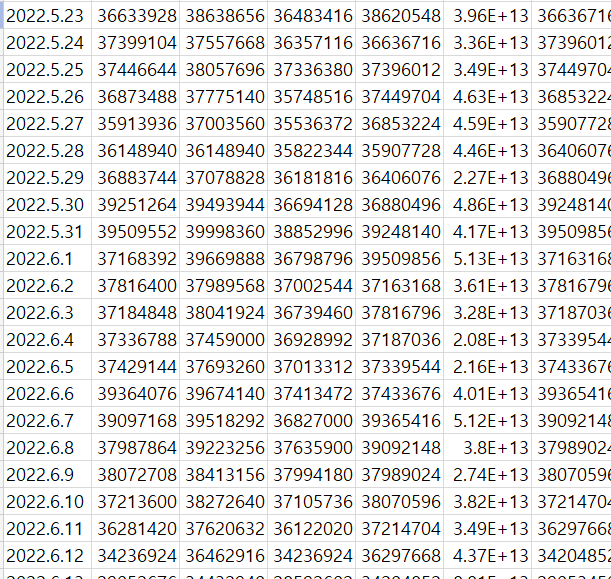

## regression

[데이터 Feature 추가]

[TEST DATA]<br>
 0: 1,285.25 <--> 1,331.62 (Loss:         46.36)<br>
 1: 1,261.28 <--> 1,284.38 (Loss:         23.10)<br>
 2: 1,333.97 <--> 1,373.29 (Loss:         39.33)<br>
 3: 1,239.68 <--> 1,334.58 (Loss:         94.90)<br>
 4: 1,292.19 <--> 1,360.09 (Loss:         67.90)<br>
 5: 1,322.44 <--> 1,302.60 (Loss:         19.84)<br>
 6: 1,334.01 <--> 1,378.05 (Loss:         44.04)<br>
 7: 1,267.17 <--> 1,380.87 (Loss:        113.70)<br>
 8: 1,298.01 <--> 1,390.43 (Loss:         92.42)<br>
 9: 1,246.55 <--> 1,319.45 (Loss:         72.89)<br>

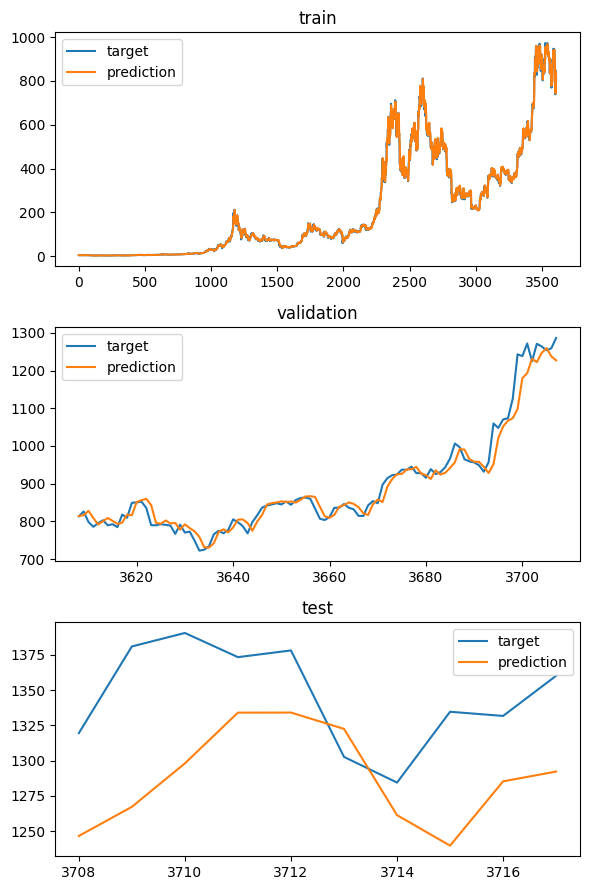

[데이터 Feature 추가 x]

[TEST DATA]<br>
 0: 1,317.31 <--> 1,360.09 (Loss:         42.78)<br>
 1: 1,264.03 <--> 1,334.58 (Loss:         70.55)<br>
 2: 1,351.35 <--> 1,302.60 (Loss:         48.74)<br>
 3: 1,265.02 <--> 1,319.45 (Loss:         54.43)<br>
 4: 1,287.55 <--> 1,284.38 (Loss:          3.17)<br>
 5: 1,324.97 <--> 1,390.43 (Loss:         65.46)<br>
 6: 1,310.62 <--> 1,331.62 (Loss:         20.99)<br>
 7: 1,357.86 <--> 1,373.29 (Loss:         15.43)<br>
 8: 1,363.01 <--> 1,378.05 (Loss:         15.04)<br>
 9: 1,288.40 <--> 1,380.87 (Loss:         92.47)<br>

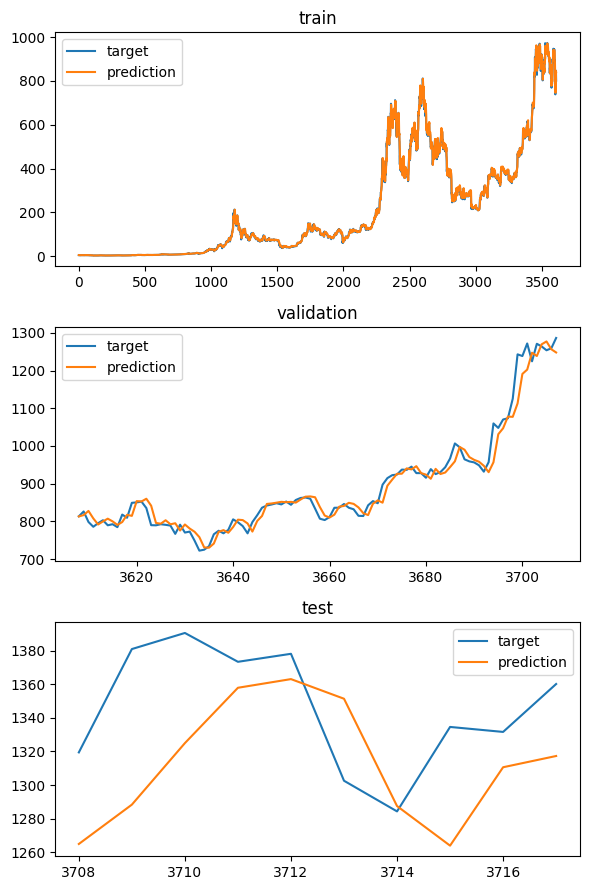

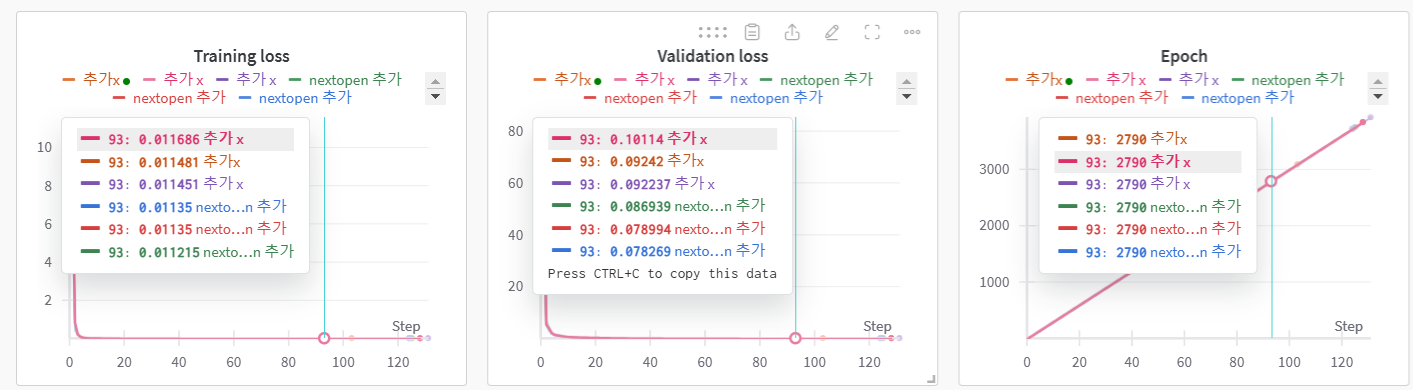

https://wandb.ai/tjsdn052-korea-university-of-technology-and-education5144/lstm_regression_btc_krw_vs?nw=nwusertjsdn052

## classification

[데이터 Feature 추가]

[TEST DATA]<br>
TEST RESULTS: 60.000%<br>
 0:   1.00 <-->   1.00<br>
 1:   1.00 <-->   1.00<br>
 2:   1.00 <-->   0.00<br>
 3:   1.00 <-->   0.00<br>
 4:   1.00 <-->   1.00<br>
 5:   1.00 <-->   1.00<br>
 6:   0.00 <-->   0.00<br>
 7:   0.00 <-->   1.00<br>
 8:   1.00 <-->   0.00<br>
 9:   1.00 <-->   1.00<br>

[데이터 Feature 추가X ]

TEST RESULTS: 70.000%<br>
 0:   1.00 <-->   1.00<br>
 1:   1.00 <-->   0.00<br>
 2:   1.00 <-->   1.00<br>
 3:   1.00 <-->   1.00<br>
 4:   1.00 <-->   1.00<br>
 5:   1.00 <-->   1.00<br>
 6:   0.00 <-->   0.00<br>
 7:   1.00 <-->   0.00<br>
 8:   1.00 <-->   0.00<br>
 9:   1.00 <-->   1.00<br>

https://wandb.ai/tjsdn052-korea-university-of-technology-and-education5144/lstm_classification_btc_krw_vs?nw=nwusertjsdn052

regression 문제의 경우 wandb 상으로는 v_loss가 데이터 Feature 추가한쪽이 확실히 우위에 있다. 하지만 문제2에서 같은 조건으로 v_loss가 0.6XX대까지 내려갔었는데 이것과 비교하면 우위가 아닌것으로 보인다. 결과 그래프를 봐도 의미있는 차이는 나지않는것으로 보이며  classification 문제에 경우는 wandb 상으로는 우위를 가릴수가 없이 골고루 퍼져있으며 테스트 결과상으로는 추가x 70% vs 추가o 60%로 퍼센트만 봤을땐 의미 있어보이지만 v_loss 상으로는 별 차이가 없던것으로 보아 테스트 케이스를 더 많이 잡으면 비슷해질것이라 생각된다. 별 영향이 없던 이유로는 이미 Feature들이 충분히 필요한 정보를 포함하고 있어, Next_Open이 새로운 정보를 제공하지 못한 것으로 보인다. 예측 대상에 직접적인 영향을 미치지 않는 특성이기 때문에 회귀나 분류 모두에서 큰 차이를 만들지 못한 것이며 다음날 Open과 같아서 새로운 정보가 아니기 때문에 별 영향이 없었던것이라고 생각한다.

### 숙제후기

레이어 늘리고 가중치 감소, 드롭아웃 적용하면 안한것보다는 확실히 나은 결과를 보여줄것이라고 생각했다. 직접 값을 대입하여 결과를 확인해보니 이 문제에서는 오히려 넣지 않는것이 더 도움이 되는것을 확인했으며 다시한번 느꼈지만 적절한 파라미터 값을 찾는게 상당히 어려운것같으며 <br>

• LSTM	layers 개수 변경<br>
• Linear	Layer	개수 변경<br>
• weight decay 값 변경<br>
• dropout	rate 값 변경<br>

이 4개 값 말고도 다른 파라미터도 변경 가능했으면 더 나은 결과를 얻었을거같다. 분류 문제의 경우는 결과 개선이 잘 안되던데 데이터 특징의 문제인지 아니면 적절한 파라미터 및 모델 구성을 하지 못하여서 그런지 궁금한다.